# Link Prediction

_A hidden connection is stronger than an obvious one_ - Heraclitus

Concepts:
- Link prediction
- Accuracy

In [1]:
import zipfile
import io
import numpy as np
import pandas as pd
from pandas import DataFrame, Series
from sklearn import metrics
import matplotlib.pyplot as plt
import networkx as nx
from finds.database import SQL, RedisDB
from finds.structured import CRSP, BusDay, PSTAT
from finds.readers import requests_get
from finds.recipes import graph_info
from secret import credentials, paths
# %matplotlib qt
VERBOSE = 0

In [2]:
sql = SQL(**credentials['sql'], verbose=VERBOSE)
bd = BusDay(sql, verbose=VERBOSE)
rdb = RedisDB(**credentials['redis'])
pstat = PSTAT(sql, bd, verbose=VERBOSE)
crsp = CRSP(sql, bd, rdb, verbose=VERBOSE)

Retrieve TNIC schemes from Hoberg and Phillips website

Source: https://hobergphillips.tuck.dartmouth.edu/industryclass.htm


In [3]:
root = 'https://hobergphillips.tuck.dartmouth.edu/idata/'
tnic_data = {}
for scheme in ['tnic2', 'tnic3']:
    source = root + scheme + '_data.zip'
    if source.startswith('http'):
        response = requests_get(source)
        source = io.BytesIO(response.content)
    with zipfile.ZipFile(source).open(scheme + "_data.txt") as f:
        tnic_data[scheme] = pd.read_csv(f, sep='\s+')
for k,v in tnic_data.items():
    print(k, v.shape)

tnic2 (50402140, 4)
tnic3 (25657918, 4)


In [4]:
# extract last year of both tnic schemes, merge in permno, and require in univ
year = 2021
capsize = 10  # large cap (large than NYSE median)
univ = crsp.get_universe(bd.endyr(year))
univ = univ[univ['decile'] <= capsize]   
lookup = pstat.build_lookup('gvkey', 'lpermno', fillna=0)
nodes = {}
tnic = {}
edges = {}
for scheme in ['tnic2', 'tnic3']:
    tnic[scheme] = tnic_data[scheme][tnic_data[scheme].year == year].dropna()
    gvkeys = sorted(set(tnic[scheme]['gvkey1']).union(tnic[scheme]['gvkey2']))
    df = DataFrame(index=gvkeys, data=lookup(gvkeys), columns=['permno'])
    nodes[scheme] = df[df['permno'].gt(0)
                       & df['permno'].isin(univ.index)].drop_duplicates()
nodes['tnic2'] = nodes['tnic2'][nodes['tnic2'].index.isin(nodes['tnic3'].index)]
nodes['tnic3'] = nodes['tnic3'][nodes['tnic3'].index.isin(nodes['tnic2'].index)]

In [5]:
# create graphs of tnic2 (denser graph) and tnic3 (sparser graph) schemes
for scheme in ['tnic2', 'tnic3']:
    e = tnic[scheme][tnic[scheme]['gvkey1'].isin(nodes[scheme].index) &
                     tnic[scheme]['gvkey2'].isin(nodes[scheme].index)]
    edges[scheme] = list(e[['gvkey1', 'gvkey2', 'score']]\
                         .itertuples(index=False, name=None))

tnic2 nodes = 3620 edges = 1051648
tnic3 nodes = 3620 edges = 690372


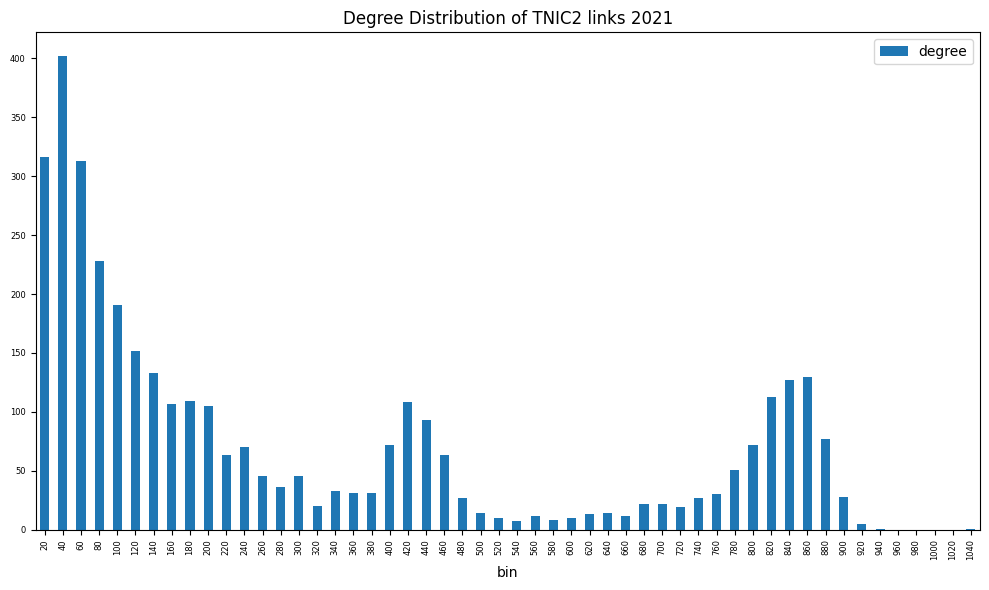

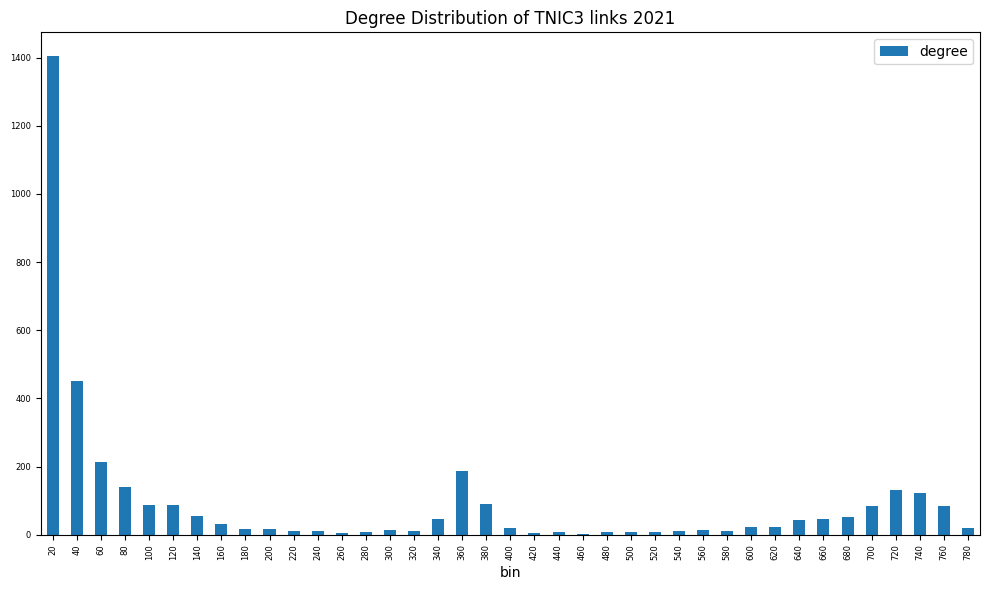

In [6]:
results = {}
G = {}
for (scheme, node), (_, edge) in zip(nodes.items(), edges.items()):
    print(scheme, 'nodes =', len(node), 'edges =', len(edge))

    # populate graph
    g = nx.Graph()
    g.add_nodes_from(node.index)
    g.add_weighted_edges_from(edge)

    # remove self-loops: not necessary
    g.remove_edges_from(nx.selfloop_edges(g))

    # graph info
    results[scheme] = Series(graph_info(g, fast=True))

    # Plot degree distribution
    fig, ax = plt.subplots(clear=True, figsize=(10, 6))
    degree = nx.degree_histogram(g)
    degree = DataFrame(data={'degree': degree[1:]},   # exclude degree 0
                       index=np.arange(1, len(degree)))
    degree['bin'] = (degree.index // (2*capsize) + 1) * (2*capsize)
    degree.groupby('bin').sum().plot(kind='bar', ax=ax, fontsize=6)
    ax.set_title(f'Degree Distribution of {scheme.upper()} links {year}')
    plt.tight_layout()

    G[scheme] = g

In [7]:
print(f"Graph properties of TNIC schemes {year}") 
DataFrame(results)

Graph properties of TNIC schemes 2021


,tnic2,tnic3
transitivity,0.839705,0.880754
average_clustering,0.596602,0.581718
connected,True,False
connected_components,1,24
size_largest_component,3620,3587
directed,False,False
weighted,True,True
negatively_weighted,False,False
edges,525824,345186
nodes,3620,3620


## Link prediction algorithms

TODO

The goal of link prediction is to predict missing or future
connections between nodes in a network. Given a partially observed
network, link prediction infers which links are
most likely to be added or missing based on the observed connections
and the structure of the network.

- jaccard_coefficient
- resource_allocation
- adamic_adar
- preferential_attachment


In [8]:
# helper to call link prediction algorithms
def link_prediction(G):
    """Predict link scores for all nonexistent edges in graph"""
    
    def links(links):
        """returns list of edge-score 3-tuples sorted by highest score"""
        return sorted(links, key=lambda x: x[2], reverse=True)
    
    resource = links(nx.resource_allocation_index(G))
    jaccard = links(nx.jaccard_coefficient(G))
    adamic = links(nx.adamic_adar_index(G))
    preferential = links(nx.preferential_attachment(G))
    return {'resource_allocation': resource,
            'jaccard_coefficient': jaccard,
            'adamic_adar': adamic,
            'preferential_attachment': preferential}

In [9]:
links = link_prediction(G['tnic3'])

## Accuracy metrics

TODO

### ROC Curve

- AUC

### Precision Recall

FP, FN, TP, TN

- precision
- recall
- accuracy
- confusion matrix
- F1 score: when imbalanced class distribution, and looking for a
  balanced measure between precision and recall (Type I and Type II
  errors).  Harmonic mean of the precision and recall

$$2 \dfrac{precision \cdot recall}{precision + recall} = \dfrac{TP}{TP + (FP+FN)/2}$$



In [10]:
def make_sample(prediction, edges):
    """helper to extract predicted scores and gold labels"""
    names = [e[:2] for e in prediction]         # node-pairs of nonexistent edges
    scores = [e[-1] for e in prediction]        # predicted scores (ordered)
    gold = [e[:2] in edges for e in prediction] # gold labels of nonexistent edges
    return gold, scores, names  # actual, predicted score, names

Classification Report: resource_allocation
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   6024566
        True       0.63      0.63      0.63    180638

    accuracy                           0.98   6205204
   macro avg       0.81      0.81      0.81   6205204
weighted avg       0.98      0.98      0.98   6205204

Classification Report: jaccard_coefficient
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   6024566
        True       0.60      0.60      0.60    180638

    accuracy                           0.98   6205204
   macro avg       0.79      0.79      0.79   6205204
weighted avg       0.98      0.98      0.98   6205204

Classification Report: adamic_adar
              precision    recall  f1-score   support

       False       0.99      0.99      0.99   6024566
        True       0.59      0.59      0.59    180638

    accuracy                           0.98   6205204
   macr

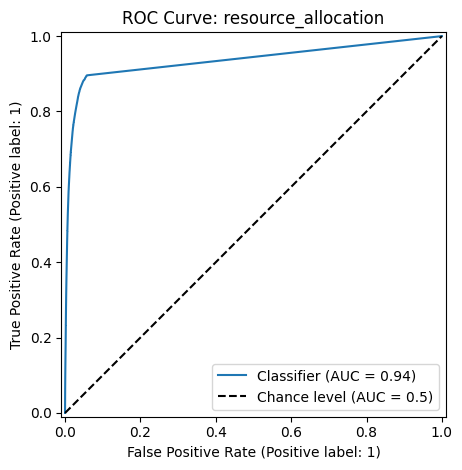

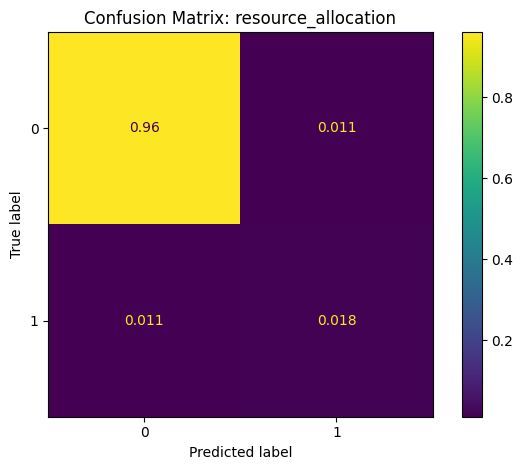

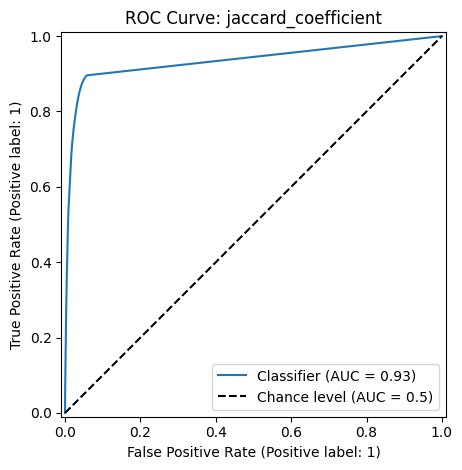

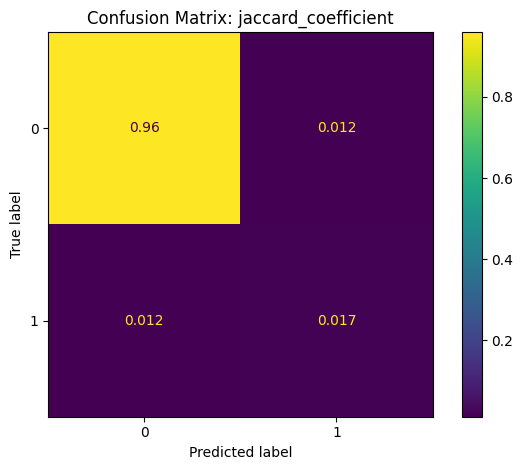

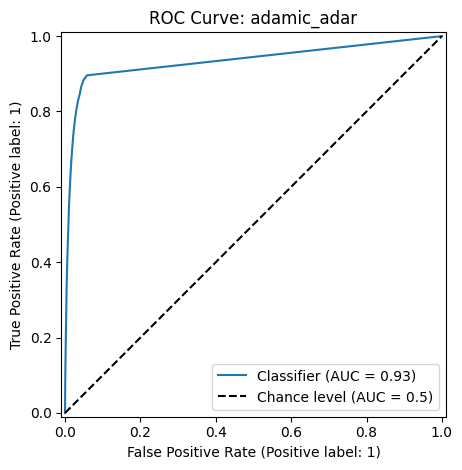

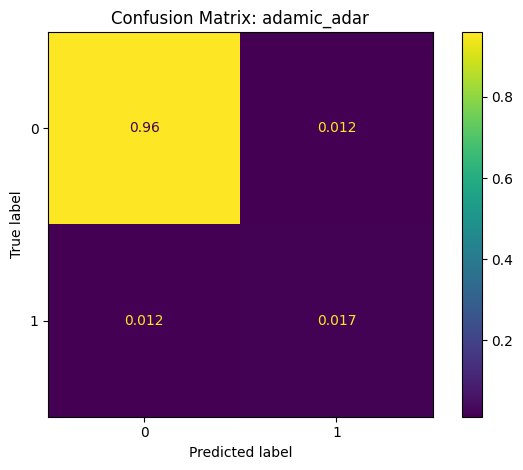

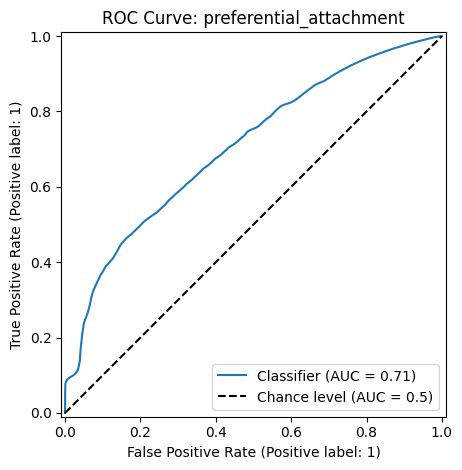

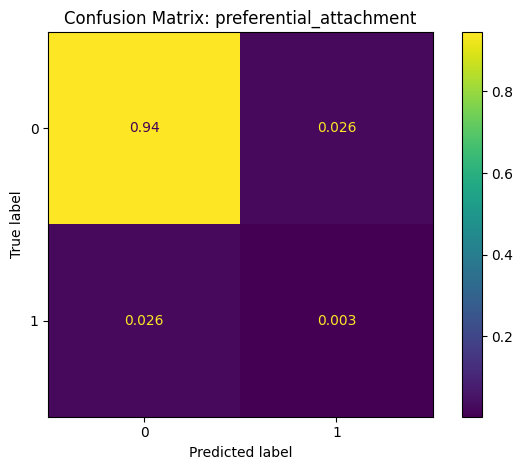

In [11]:
report = {}
for ifig, (method, pred) in enumerate(links.items()):

    # extract predicted scores and gold labels of nonexistent edges
    y, scores, names = make_sample(pred, G['tnic2'].edges)

    # plot roc curve
    metrics.RocCurveDisplay.from_predictions(y_true=y, y_pred=scores,
                                             plot_chance_level=True)
    plt.title(f"ROC Curve: {method}")
    plt.tight_layout()
    
    # set classification threshold at class proportion
    thresh = scores[sum(y)] 
    y_pred = [score >= thresh for score in scores]

    # generate and plot confusion matrix
    cm = metrics.confusion_matrix(y_true=y, y_pred=y_pred, normalize='all')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f"Confusion Matrix: {method}")
    plt.tight_layout()
    
    # generate classification report
    report[method] = metrics.classification_report(y_true=y, y_pred=y_pred)
    print(f"Classification Report: {method}")
    print(report[method])